### Parse `UR5e` in `MuJoCo`

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import mujoco
import mujoco_viewer
np.set_printoptions(precision=2,suppress=True,linewidth=100)
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
print ("MuJoCo version:[%s]"%(mujoco.__version__))

MuJoCo version:[2.3.2]


### Parse `UR5e`

In [2]:
xml_path='../model/ur5e/ur5.xml'
full_xml_path = os.path.abspath(os.path.join(os.getcwd(),xml_path))
model = mujoco.MjModel.from_xml_path(full_xml_path)
data = mujoco.MjData(model)
mujoco.mj_resetData(model, data) # reset
print ("[UR5e] parsed.")

[UR5e] parsed.


In [3]:
n_body          = model.nbody # number of bodies
body_names      = [mujoco.mj_id2name(model,mujoco.mjtObj.mjOBJ_BODY,x) for x in range(n_body)]
n_joint         = model.njnt     # number of joints
joint_names     = [mujoco.mj_id2name(model,mujoco.mjtJoint.mjJNT_HINGE,x) for x in range(n_joint)]
joint_types     = model.jnt_type # joint types
joint_ranges    = model.jnt_range # joint ranges
rev_joint_idxs  = np.where(joint_types==mujoco.mjtJoint.mjJNT_HINGE)[0].astype(np.int32)
rev_joint_names = [joint_names[x] for x in rev_joint_idxs]
n_rev_joint     = len(rev_joint_idxs)
rev_joint_min   = joint_ranges[rev_joint_idxs,0]
rev_joint_max   = joint_ranges[rev_joint_idxs,1]
rev_joint_range = rev_joint_max - rev_joint_min
pri_joint_idxs  = np.where(joint_types==mujoco.mjtJoint.mjJNT_SLIDE)[0].astype(np.int32)
pri_joint_names = [joint_names[x] for x in pri_joint_idxs]
n_pri_joint     = len(pri_joint_idxs)
# Print
print ("n_body:[%d]"%(n_body))
print ("body_names:%s"%(body_names))
print ("n_joint:[%d]"%(n_joint))
print ("joint_names:%s"%(joint_names))
print ("joint_types:%s"%(joint_types))
print ("joint_ranges:\n%s"%(joint_ranges))
print ("n_rev_joint:[%d]"%(n_rev_joint))
print ("rev_joint_idxs:%s"%(rev_joint_idxs))
print ("rev_joint_names:%s"%(rev_joint_names))
print ("rev_joint_min:%s"%(rev_joint_min))
print ("rev_joint_max:%s"%(rev_joint_max))
print ("rev_joint_range:%s"%(rev_joint_range))
print ("n_pri_joint:[%d]"%(n_pri_joint))
print ("pri_joint_idxs:%s"%(pri_joint_idxs))
print ("pri_joint_names:%s"%(pri_joint_names))

n_body:[19]
body_names:['world', 'box_link', 'ur_base_link', 'ur_shoulder_link', 'ur_upper_arm_link', 'ur_forearm_link', 'ur_wrist_1_link', 'ur_wrist_2_link', 'ur_wrist_3_link', 'ur_tcp_link', 'camera_mount', 'ur_rg2_gripper_base_link', 'rg2_gripper_finger1_finger_link', 'rg2_gripper_finger1_inner_knuckle_link', 'rg2_gripper_finger1_finger_tip_link', 'rg2_gripper_finger2_finger_link', 'rg2_gripper_finger2_inner_knuckle_link', 'rg2_gripper_finger2_finger_tip_link', 'base']
n_joint:[7]
joint_names:['ur_shoulder_pan_joint', 'ur_shoulder_lift_joint', 'ur_elbow_joint', 'ur_wrist_1_joint', 'ur_wrist_2_joint', 'ur_wrist_3_joint', 'ur_tcp_joint']
joint_types:[3 3 3 3 3 3 3]
joint_ranges:
[[-3.14  3.14]
 [-3.14  3.14]
 [-3.14  3.14]
 [-3.14  3.14]
 [-3.14  3.14]
 [-3.14  3.14]
 [-3.14  3.14]]
n_rev_joint:[7]
rev_joint_idxs:[0 1 2 3 4 5 6]
rev_joint_names:['ur_shoulder_pan_joint', 'ur_shoulder_lift_joint', 'ur_elbow_joint', 'ur_wrist_1_joint', 'ur_wrist_2_joint', 'ur_wrist_3_joint', 'ur_tcp_join

### Get `image`

Pressed ESC
Quitting.
tick:[176] [1.75]sec. Done.


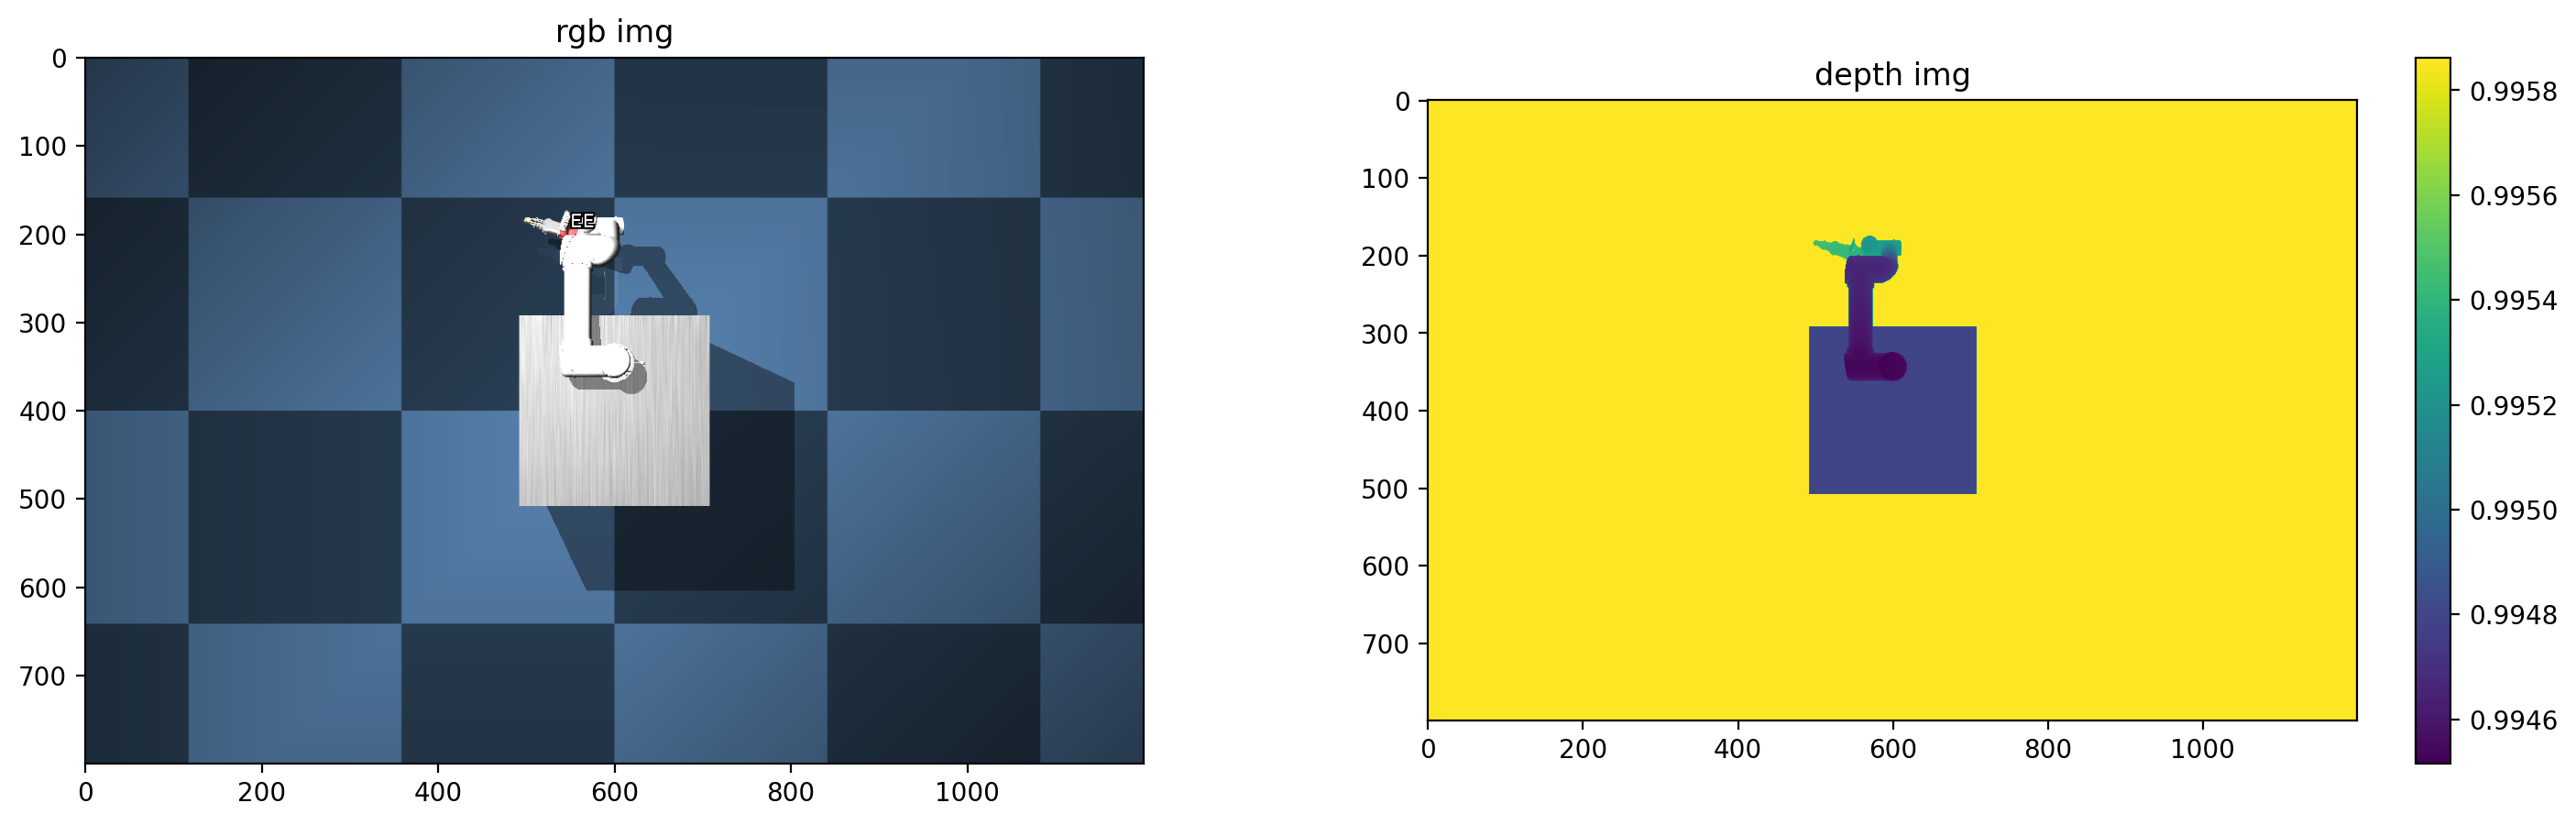

In [4]:
import copy

# Viewer
viewer = mujoco_viewer.MujocoViewer(model,data,mode='window',
    title='UR5e in MuJoCo',width=1200,height=800,hide_menus=True)
viewer.cam.azimuth   = 0.0
viewer.cam.distance  = 0.0
viewer.cam.elevation = -90.0    # -90
viewer.cam.lookat = np.array([0.0,0.0,4.0])

# simulate and render
mujoco.mj_resetData(model, data)
mujoco.mj_forward(model, data)

dt = model.opt.timestep
nstep = 5
# Buffers
tick = 0
max_time = 100 # (second)
imgs,img_ticks = [],[]
depth_imgs = [] # depth images

while data.time < max_time:
    tick = tick + 1
    if viewer.is_alive:
        # Update
        mujoco.mj_step(model,data,nstep=nstep)

        # Add sphere marker
        viewer.add_marker(
            pos   = data.body('ur_rg2_gripper_base_link').xpos,
            size  = [0.05,0.05,0.05],
            rgba  = [1,0,0,0.3],
            type  = mujoco.mjtGeom.mjGEOM_SPHERE,
            label = 'EE')

        # Render
        viewer.render()
    else: break # terminate if viewer is dead

    # Grab image
    every_second = 1 # (second)
    if (tick % int(every_second/dt/nstep)) == 0:
        mujoco.mjr_render(viewer.viewport, viewer.scn, viewer.ctx)
        img = np.zeros((viewer.viewport.height,viewer.viewport.width,3),dtype=np.uint8)
        depth_img = np.zeros((viewer.viewport.height,viewer.viewport.width, 1), dtype=np.float32)
        mujoco.mjr_readPixels(img, depth_img, viewer.viewport, viewer.ctx) # this makes a little delay
        img = np.flipud(img) # flip image
        depth_img = np.flipud(depth_img) # flip image
        imgs.append(img)
        depth_imgs.append(depth_img)
        img_ticks.append(tick)

# close viewer
viewer.close() 
print ("tick:[%d] [%.2f]sec. Done."%(tick,data.time))

plt.figure(figsize=(18,5))
plt.subplot(1,2,1)
plt.imshow(img)
plt.title("rgb img")
# plt.show()

plt.subplot(1,2,2)
plt.imshow(depth_img)
plt.title("depth img")
plt.colorbar()
plt.show()

### convert depth values to `meter` scale

In [6]:
def depth2meters(model, depth_image):

    extend = model.stat.extent
    near = model.vis.map.znear * extend
    far = model.vis.map.zfar * extend
    depth_scale = (1-near/far)
    depth_image = [i * depth_scale for i in depth_image]
    depth_image = [near / (1-i) for i in depth_image]

    return np.array(depth_image)

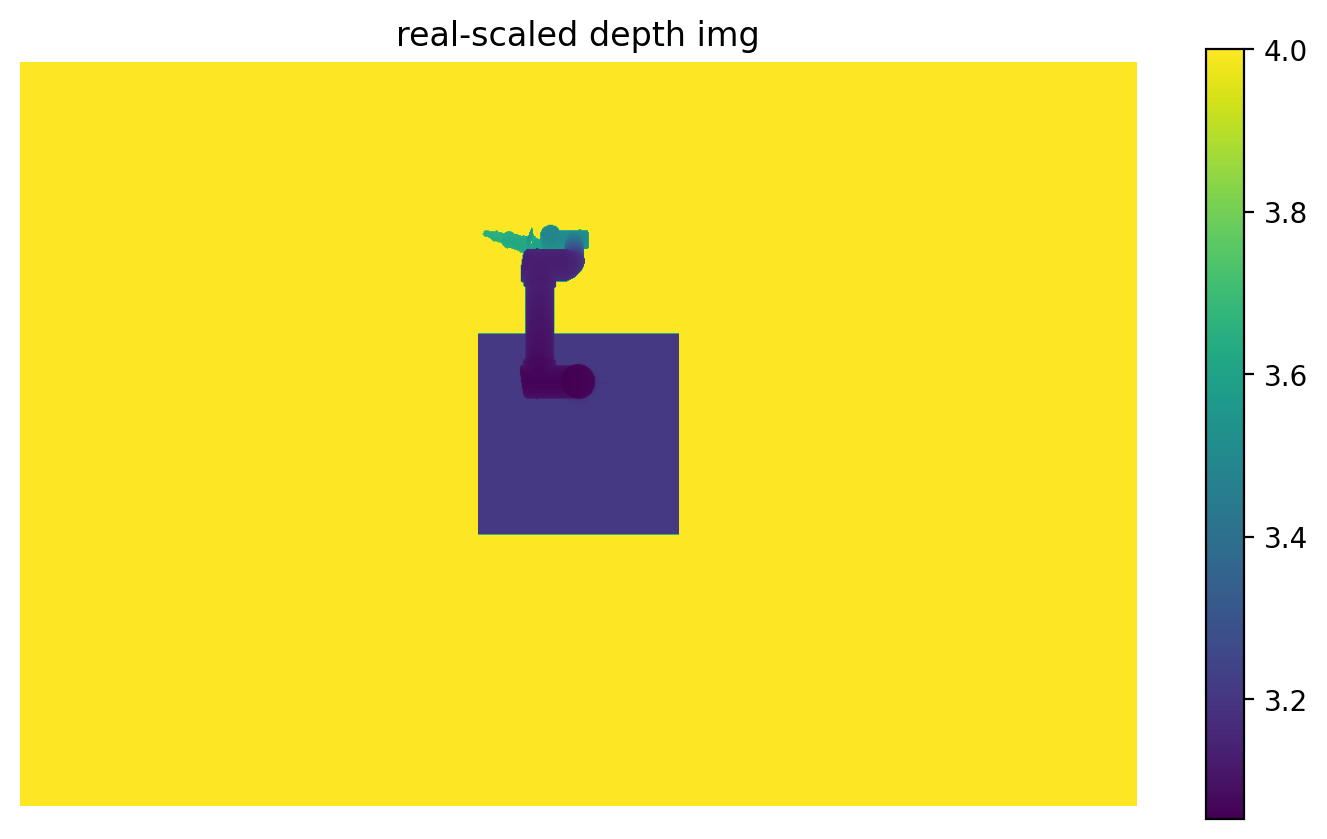

In [7]:
real_scaled_depth_img = depth2meters(model, depth_img)
plt.figure(figsize=(9,5))
plt.imshow(real_scaled_depth_img)
plt.axis('off')
plt.title("real-scaled depth img")
plt.colorbar()
plt.show()